# Applied Deep Learning Task 2 (Deep Learning based Sentiment Analysis)

`Name: Gangula Karthik`<br>
`Admin No: 223715Y`

**Objective:** The objective of this project is to develop a robust sentiment analysis model for drug reviews, leveraging deep learning and NLP techniques to classify user sentiments based on their experiences with different medications.

This project will use the drug review dataset provided to build a sentiment classification model capable of accurately predicting user sentiment based on textual feedback. The model will then be trained on a second dataset to evaluate generalization performance and compare results across both datasets.

The aim will be to evaluate the model's generalization ability and bt analyzing performance across both datasets, this project seeks to identify which dataset provides better training signals, optimize model performance, and ensure adaptability to variations in writing styles and tones. Ultimately this approach will enhance the model’s reliability in real-world applications.

## Table of Contents

1. Importing Packages

## Importing Packages

In [1]:
# %pip install wordcloud
# %pip install kagglehub
# %pip install lingua-language-detector
# %pip install nltk
# %pip install 'tensorflow[and-cuda]'
# %pip install transformers
# %pip install tf-keras

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-02-22 22:56:31.398236: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-22 22:56:31.544444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740264991.622714    2036 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740264991.642298    2036 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 22:56:31.794435: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import os
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from lingua import LanguageDetectorBuilder, Language, IsoCode639_1, IsoCode639_3
import warnings
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from bs4 import BeautifulSoup
import string
from sklearn.model_selection import train_test_split
import re
import kagglehub
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from emojii_and_emoticon_map import EMOTICONS_EMO, EMOJI_UNICODE
# https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py is where the mapping dictionary EMOTICONS_EMO came from


nltk.download('wordnet')
detector = LanguageDetectorBuilder.from_all_languages().build()

warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Understanding

In [4]:
train_df = pd.read_csv("drug_review_train.csv", index_col="Unnamed: 0")
test_df = pd.read_csv("drug_review_test.csv",  index_col="Unnamed: 0")

In [5]:
print("TRAINING DATASET")
display(train_df.head())
print("TESTING DATASET")
display(test_df.head())

TRAINING DATASET


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,"May 11, 2016",6,140
3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104
4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74


TESTING DATASET


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,163740,Mirtazapine,depression,"""i've tried a few antidepressants over the yea...",10.0,"February 28, 2012",22,68
1,206473,Mesalamine,"crohn's disease, maintenance","""my son has crohn's disease and has done very ...",8.0,"May 17, 2009",17,48
2,39293,Contrave,weight loss,"""contrave combines drugs that were used for al...",9.0,"March 5, 2017",35,143
3,97768,Cyclafem 1 / 35,birth control,"""i have been on this birth control for one cyc...",9.0,"October 22, 2015",4,149
4,208087,Zyclara,keratosis,"""4 days in on first 2 weeks. using on arms an...",4.0,"July 3, 2014",13,60


In [6]:
train_df.describe()

,patient_id,rating,usefulCount,review_length
count,110811.000000,110811.000000,110811.000000,110811.000000
mean,116008.545000,7.007617,28.466470,95.475413
std,66948.798417,3.241435,37.620018,38.784644
min,4.000000,1.000000,0.000000,31.000000
25%,58505.500000,5.000000,6.000000,63.000000
50%,116081.000000,8.000000,16.000000,95.000000
75%,173309.000000,10.000000,37.000000,130.000000
max,232289.000000,10.000000,1291.000000,1894.000000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110811 entries, 0 to 810
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   patient_id     110811 non-null  int64  
 1   drugName       110811 non-null  object 
 2   condition      110811 non-null  object 
 3   review         110811 non-null  object 
 4   rating         110811 non-null  float64
 5   date           110811 non-null  object 
 6   usefulCount    110811 non-null  int64  
 7   review_length  110811 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 7.6+ MB


In [8]:
train_df.isna().sum()

patient_id       0
drugName         0
condition        0
review           0
rating           0
date             0
usefulCount      0
review_length    0
dtype: int64

In [9]:
train_df[train_df.duplicated()]

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length


## Exploratory Data Analysis

In [10]:
# usefulCount vs rating
# sentiment over time
# wordcloud in positive and negative reviews

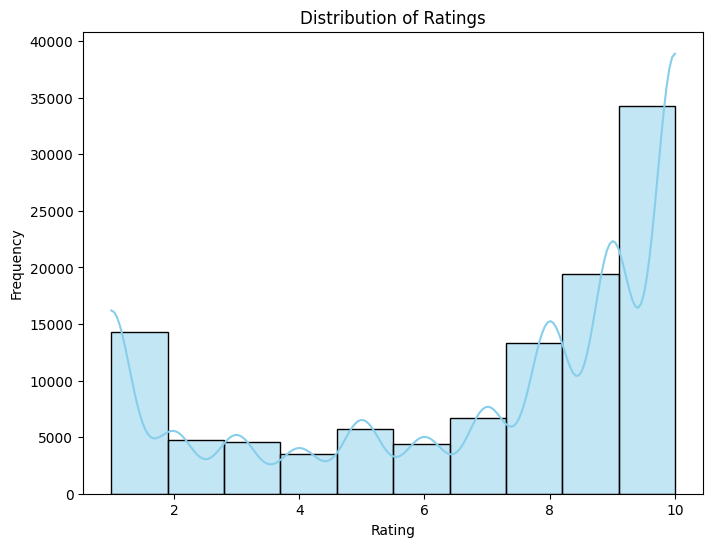

In [11]:
# Distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(train_df['rating'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Number of unique drug names
num_unique_drugs = train_df['drugName'].nunique()
print(f'Number of Unique Drug Names: {num_unique_drugs}')

Number of Unique Drug Names: 2865


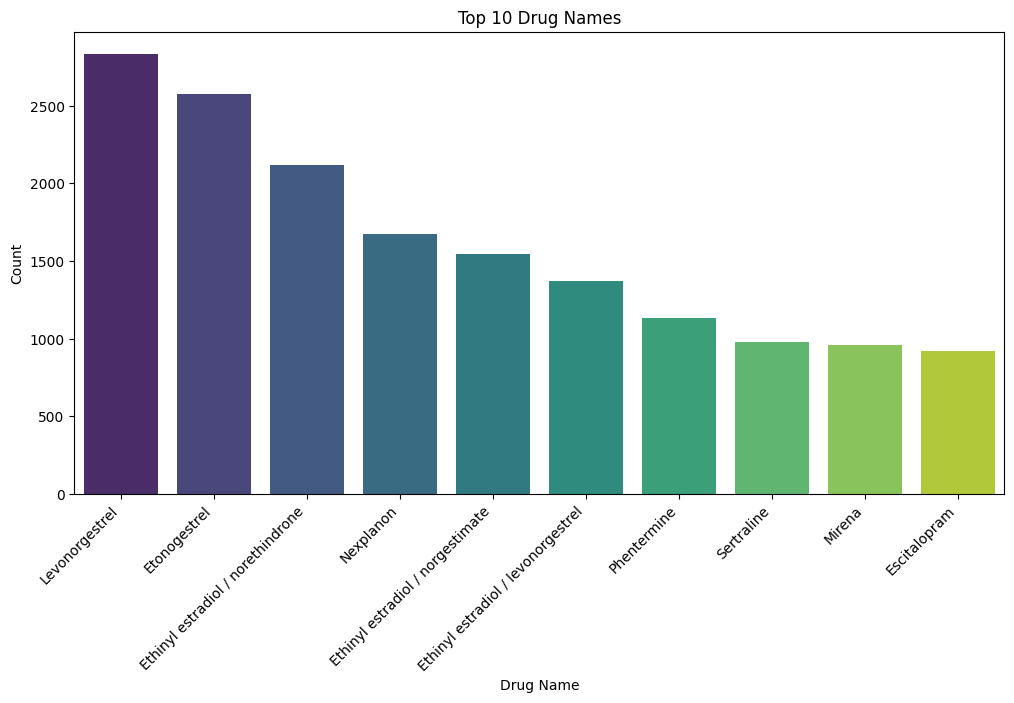

In [13]:
top_drugs = train_df['drugName'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_drugs.index, y=top_drugs.values, palette='viridis')
plt.title('Top 10 Drug Names')
plt.xlabel('Drug Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

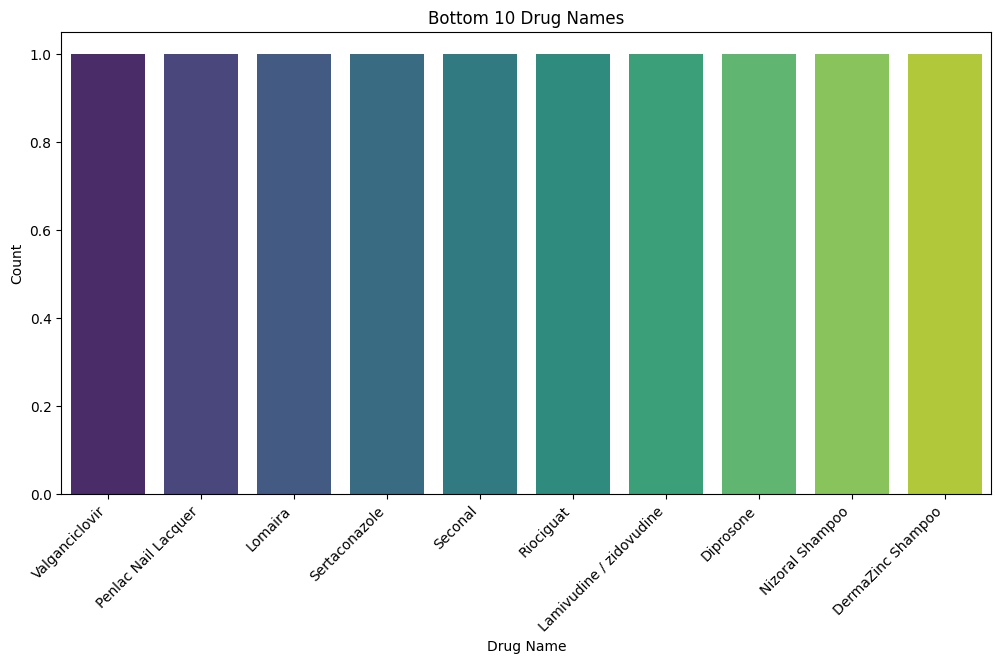

In [14]:
# Bottom 10 drug names by count
bottom_drugs = train_df['drugName'].value_counts().tail(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=bottom_drugs.index, y=bottom_drugs.values, palette='viridis')
plt.title('Bottom 10 Drug Names')
plt.xlabel('Drug Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [15]:
# Number of unique conditions
num_unique_conditions = train_df['condition'].nunique()
print(f'Number of Unique Conditions: {num_unique_conditions}')

Number of Unique Conditions: 791


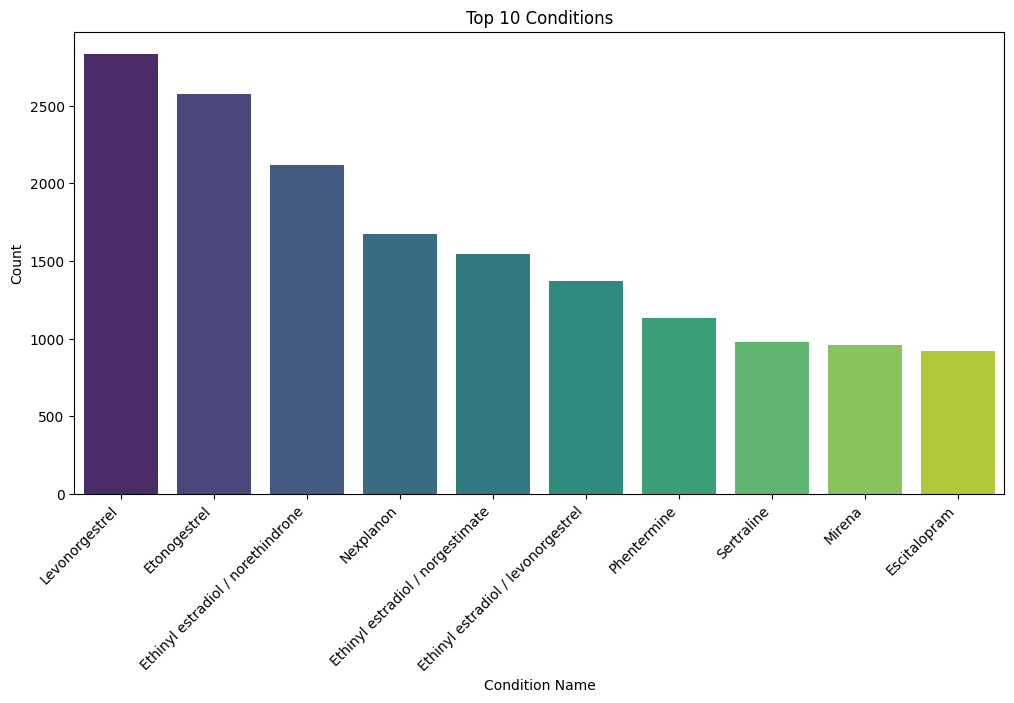

In [16]:
top_conditions = train_df['condition'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_drugs.index, y=top_drugs.values, palette='viridis')
plt.title('Top 10 Conditions')
plt.xlabel('Condition Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

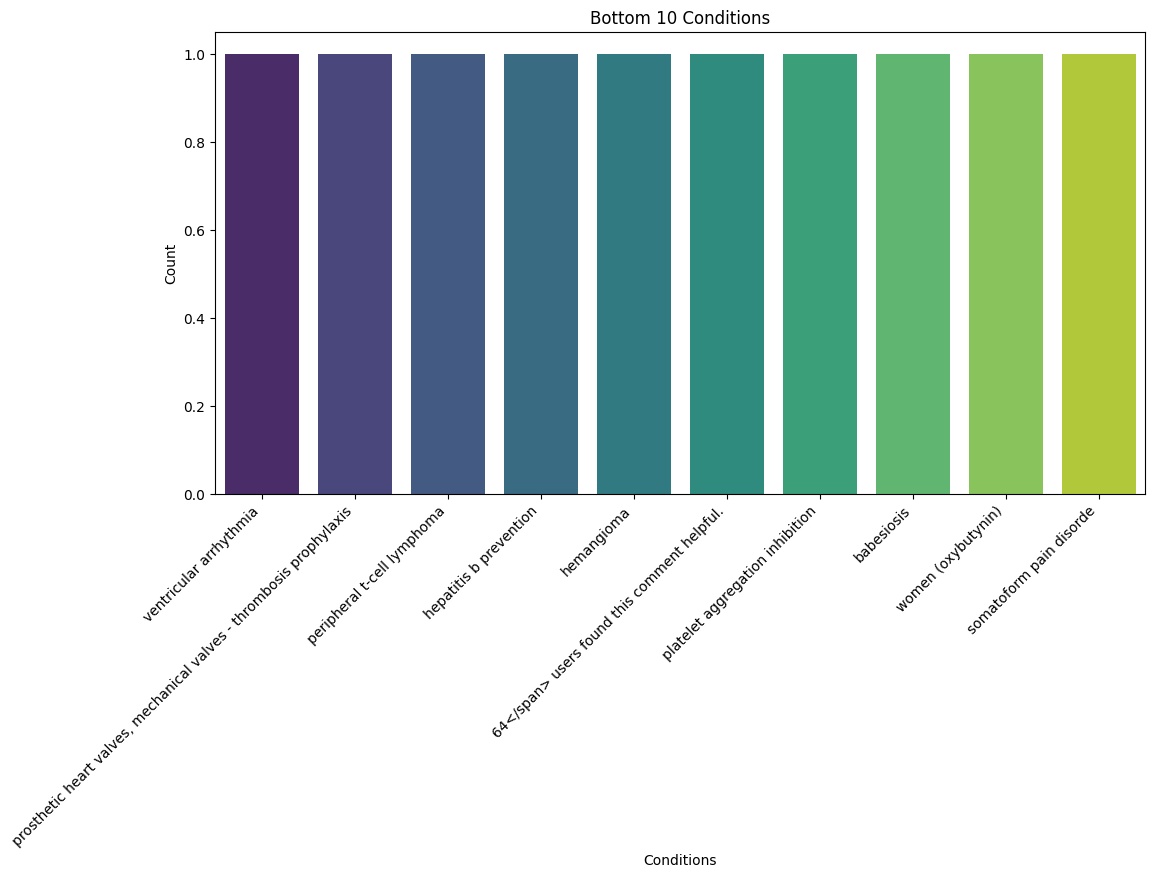

In [17]:
bottom_conditions = train_df['condition'].value_counts().tail(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=bottom_conditions.index, y=bottom_conditions.values, palette='viridis')
plt.title('Bottom 10 Conditions')
plt.xlabel('Conditions')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [18]:
# For each rating from 1 to 10, sample 5 random reviews and display them
for rating in range(1, 11):
    print(f"Rating {rating}:")
    sample_reviews = train_df[train_df['rating'] == rating]['review'].sample(n=5, random_state=42)
    for i, review in enumerate(sample_reviews):
        print(f"{i+1}. {review}")
    print("\n" + "-"*50 + "\n")

Rating 1:
1. "tried the 20 mg 10 pack free trial... tried it 5 times and saw absolutely no results... woke up every hour and a half or so the entire night.  did not feel foggy  in the morning.   with my insurance the rx would have been $90 a month. 
no thanks!"
2. " i hate the doctors that prescribe ambien  to  patients like me. they  are putting patent's life in danger.  i know some people taking this pill during the day too and they take way too much . it is adicctive"
3. "took it in 46 hours after an intercourse in which the condom tore. 4 weeks pregnant now!  cvs attendant gave this pill saying it's same as plan b. it's not!!!
spend $10 extra and get plan b! it works."
4. "i started using saxenda about a month ago - doing the increments in doses to this week at 2.4 so not quite 3 yet. first few weeks no side effects yay! then last thursday feeling nausea with extreme  ( double you over) pain so left work & hardly made it home & explosive diarrhea - left me drained, naused & sick th

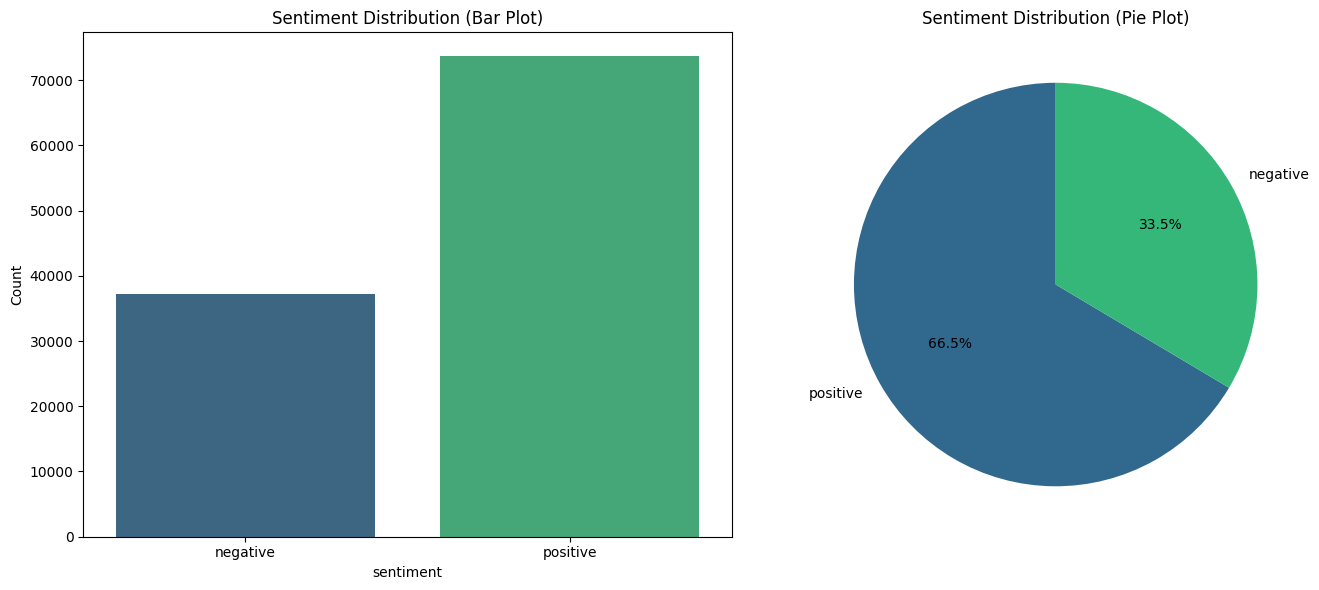

In [19]:
# Sentiment classification based on rating
train_df['sentiment'] = train_df['rating'].apply(lambda x: 'positive' if x > 6 else 'negative')


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data=train_df, x='sentiment', ax=axes[0], palette='viridis')
axes[0].set_title('Sentiment Distribution (Bar Plot)')
axes[0].set_ylabel('Count')

sentiment_counts = train_df['sentiment'].value_counts()
axes[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(sentiment_counts)))
axes[1].set_title('Sentiment Distribution (Pie Plot)')

plt.tight_layout()
plt.show()

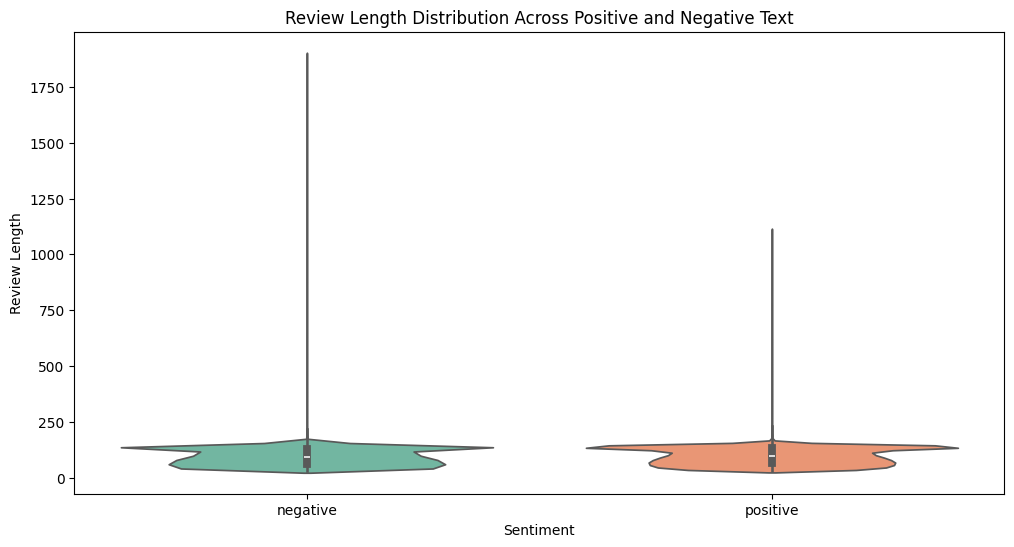

In [20]:
# Review length distribution by sentiment
plt.figure(figsize=(12, 6))
sns.violinplot(data=train_df, x='sentiment', y='review_length', palette='Set2')
plt.title('Review Length Distribution Across Positive and Negative Text')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

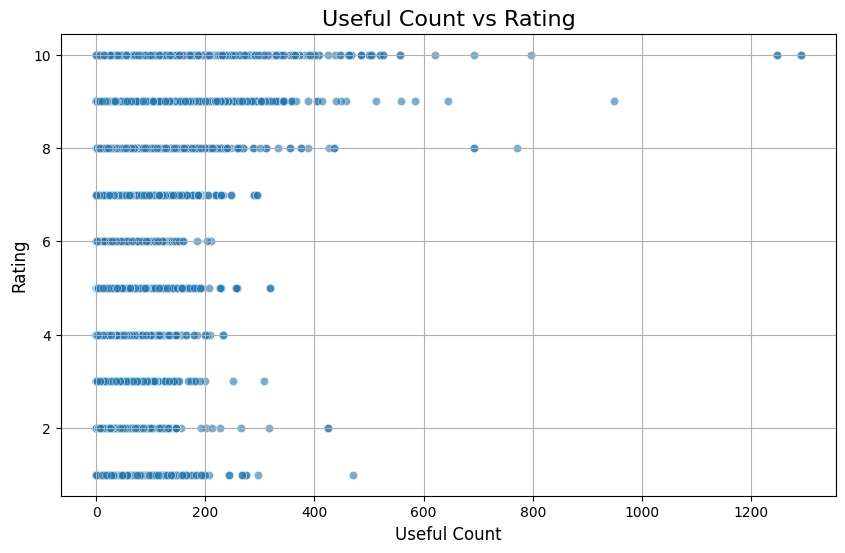

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='usefulCount', y='rating', alpha=0.6)
plt.title('Useful Count vs Rating', fontsize=16)
plt.xlabel('Useful Count', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.grid(True)
plt.show()

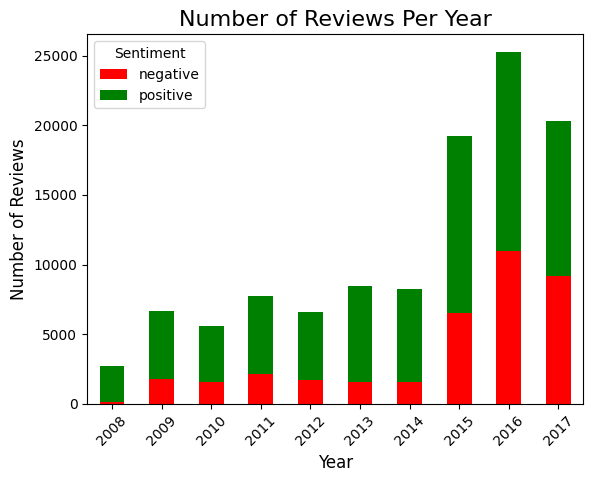

In [22]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df['year'] = train_df['date'].dt.year

sentiment_counts = train_df.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

sentiment_counts.plot(kind='bar', stacked=True, color=['red', 'green'])

plt.title('Number of Reviews Per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')

plt.show()

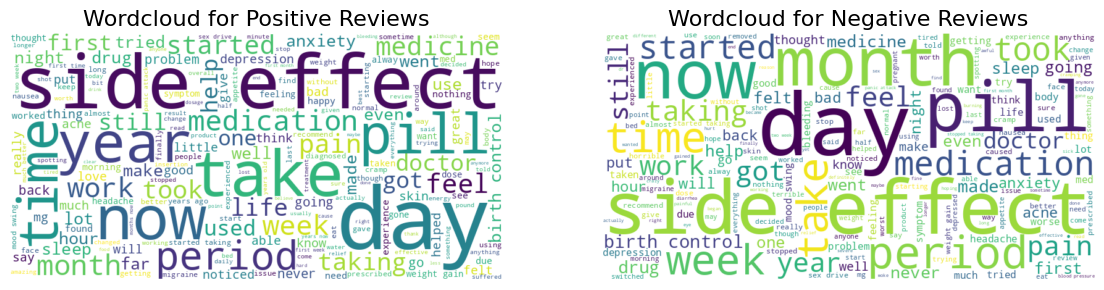

In [23]:
from wordcloud import WordCloud

# Filter for positive and negative reviews
positive_reviews = train_df[train_df['sentiment'] == 'positive']['review']
negative_reviews = train_df[train_df['sentiment'] == 'negative']['review']

# Combine reviews into one large string for each category
positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)

# Generate word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(negative_text)

# Plot positive wordcloud
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Positive Reviews', fontsize=16)

# Plot negative wordcloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Negative Reviews', fontsize=16)

plt.show()


In [24]:
def find_language_codes(text):
    cleaned_text = text.replace("\n", "") 
    return detector.detect_language_of(text)

tqdm.pandas(desc="Detecting language codes")
train_df["language_code"] = train_df["review"].progress_apply(find_language_codes)
train_df.head(3)

Detecting language codes: 100%|██████████| 110811/110811 [02:15<00:00, 816.19it/s]


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,2013-04-20,69,147,negative,2013,Language.ENGLISH
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,2016-08-07,4,136,positive,2016,Language.ENGLISH
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,2016-05-11,6,140,negative,2016,Language.ENGLISH


In [25]:
for i in train_df[train_df['language_code'] != Language.ENGLISH]['review']:
    print(i, end="\n\n")

"do not allow dr to put you on this medication if you:
are autoimmune (positive ana, rheumatoid arthritis, systemic lupus, sjögren's syndrome)
or take: 
effexor or any other snri
i am experiencing liver injury due to the combination of these conditions/drugs"

"the miracle pill!
i have constipation since my childhood.
i have try everything on the market and even change my diet with high fiber with no result. i am 53 years old and for the first time of my life ,i am regular(go every day).
i feel like a new person.i use to go once a week .constella pill just change my life!
la pilule miracle.je souffre de constipation depuis mon enfance.j'ai tout essayé sur le marché et même avec un régime à haute teneur en fibre,aucun resultat.j'ai 53 ans et pour la première fois de toute ma vie,je suis régulière(une fois tout les jour plutôt qu'une fois par semaine!)
je suis une nouvelle personne. constella a changé ma vie!"

"i was using it by a trial, for a year and im in love. my skin was clear like

In [26]:
tqdm.pandas()

def count_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    urls = re.findall(url_pattern, text)
    return len(urls)

train_df['num_urls'] = train_df['review'].progress_apply(count_urls)
print(train_df[train_df['num_urls'] > 0].shape)
display(train_df[train_df['num_urls'] > 0].head(3))

100%|██████████| 110811/110811 [00:00<00:00, 161008.61it/s]

(18, 12)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls
18,148611,Mirena,birth control,"""i love my iud for many reasons. a lot of thes...",10.0,2017-02-08,40,134,positive,2017,Language.ENGLISH,1
665,200028,Varenicline,smoking cessation,"""i took a 2 week short course with champix as ...",9.0,2015-11-01,10,121,positive,2015,Language.ENGLISH,1
5164,76520,Quazepam,not listed / othe,"""i took doral for years for meniere's until it...",9.0,2016-05-19,8,41,positive,2016,Language.ENGLISH,1


In [27]:
train_df[train_df['num_urls'] > 0].iloc[3, 3]

'"i was in the original fda fk506 study as a pre-transplant patient (primary sclerosing cholangitis ).  i had been given 6 yrs to have a liver transplant.  my liver #\'s were 3-4 digits and i was becoming very ill.  my dosage was stabilized at 3 mgs and my numbers have decreased to normal.  i have been on this medicine since 10 \'92 and still no transplant.  the medicine has slowed the progress of psc drastically.  i see it is used for crohn\'s, but nothing is listed for liver diseases.  did they ever evaluate the trial results from the early 90\'s?   my current insurance will not approve the drug for me for this reason.  this might be the result of the trial www.ncbi.nlm.nih.gov/pmc/articles/pmc2982698/ or is a similar one."'

In [28]:
def count_user_mentions(text):
    user_pattern = r'@\w+'
    mentions = re.findall(user_pattern, text)
    return len(mentions)

train_df['count_user_mentions'] = train_df['review'].progress_apply(count_user_mentions)
print(train_df[train_df['count_user_mentions'] > 0].shape)
display(train_df[train_df['count_user_mentions'] > 0].head(3))

100%|██████████| 110811/110811 [00:00<00:00, 589338.11it/s]

(63, 13)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls,count_user_mentions
329,87796,Naproxen,muscle pain,"""i have taken l x aleve 500 every morning for ...",10.0,2009-05-15,26,67,positive,2009,Language.ENGLISH,0,1
1331,178745,Victoza,"diabetes, type 2","""i started taking victoza february 2015 @the s...",8.0,2015-10-27,23,137,positive,2015,Language.ENGLISH,0,1
2836,126179,Viibryd,depression,"""my doc gave me a titration pack of viibryd an...",7.0,2012-05-22,15,144,positive,2012,Language.ENGLISH,0,1


In [29]:
train_df[train_df['count_user_mentions'] > 0].iloc[3, 3]

'"i have bipolar disorder and generalized anxiety. i take bupropion daily and xanax (0.5-1 mg as needed) usually twice a day. i started 3 days ago on 5mg olanzapine (@bedtime) .  wow.  noticed much more stable mood on day 1.  today is day 3 and again, very stable mood and sleeping through the night since starting and am very happy with these results so far.  i have not had a need for xanax since starting. the only side effect i am experiencing so far is fatigue in the morning hours - no change in appetite or other effects mentioned by others in this column.  i will post again in a few months to update my results.  "'

In [30]:
def has_numbers(text):
    number_pattern = r'\b\d+([.,]\d+)*\b'
    return bool(re.search(number_pattern, text))

train_df['has_numbers'] = train_df['review'].progress_apply(has_numbers)
print(train_df[train_df['has_numbers'] > 0].shape)
display(train_df[train_df['has_numbers'] > 0].head(3))

100%|██████████| 110811/110811 [00:00<00:00, 158702.39it/s]


(83858, 14)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls,count_user_mentions,has_numbers
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,2013-04-20,69,147,negative,2013,Language.ENGLISH,0,0,True
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,2016-08-07,4,136,positive,2016,Language.ENGLISH,0,0,True
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,2016-05-11,6,140,negative,2016,Language.ENGLISH,0,0,True


In [31]:
train_df[train_df['has_numbers'] > 0].iloc[3, 3]

'"i recommend taking as prescribed, and the bottle usually says "take x amount every x hours". i think that having a steady stream of any medication is the only way to have it work. this medication\'s only side effect i have found is almost exactly like when one takes benadryl, and only when you are first starting out on it. i am used to it now after 3 weeks and the only effect i notice is that my hands no longer shake and my mind is at ease. much better and smoother than other meds like xanax or tramadol or klonopin, etc., etc. "'

In [32]:
def count_hashtags(text):
    hashtag_pattern = r'#\S+'
    hashtags = re.findall(hashtag_pattern, text)
    return len(hashtags)

train_df['count_hashtags'] = train_df['review'].progress_apply(count_hashtags)
print(train_df[train_df['count_hashtags'] > 0].shape)
display(train_df[train_df['count_hashtags'] > 0].head(3))

100%|██████████| 110811/110811 [00:00<00:00, 574379.21it/s]


(319, 15)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls,count_user_mentions,has_numbers,count_hashtags
337,131103,Altavera,birth control,"""#1 it gave me acne. #2 i gained so much weigh...",1.0,2015-12-30,4,61,negative,2015,Language.ENGLISH,0,0,True,3
862,220288,Amitriptyline,migraine prevention,"""i had daily migraines for several years. i ha...",9.0,2012-06-18,32,124,positive,2012,Language.ENGLISH,0,0,True,1
922,211161,Aftera,emergency contraception,"""sunday i had unprotected sex, wasn't sure if ...",10.0,2016-03-29,13,117,positive,2016,Language.ENGLISH,0,0,True,1


In [33]:
train_df[train_df['count_hashtags'] > 0].iloc[3, 3]

'"i\'ve had cold sores since i was a child. it\'s embarrassing and ghastly to look at. i\'m now 32 and i\'ve figured out the best remedies to prevent or speed up healing time. \r\r\nthe #1 best medication is l-lysine. i take 1000 mg capsules (nature\'s bounty) at the first sign of an itch, tingle or irritation. i take no chances! since taking l-lysine i haven\'t had one form yet. dry lips on windy days, runny nose and stress are my triggers. \r\r\n#2 is ice.  freezing it prevents the blisters from forming. the virus thrives in warm, moist areas. use #3 rubbing alcohol w/ ice to dry out sore. for those naturopaths, #4 turmeric is great in stopping blisters from spreading. it\'s a natural anti-inflammatory and the virus is unable to thrive. best of luck!!!"'

In [34]:
def count_elongated_words(text):
    elongated_pattern = r'\b(\S*?)(.)\2{2,}\b'
    elongated_words = re.findall(elongated_pattern, text)
    return len(elongated_words)

train_df['count_elongated_words'] = train_df['review'].progress_apply(count_elongated_words)
print(train_df[train_df['count_elongated_words'] > 0].shape)
display(train_df[train_df['count_elongated_words'] > 0].head(3))

100%|██████████| 110811/110811 [00:05<00:00, 21591.60it/s]

(8490, 16)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls,count_user_mentions,has_numbers,count_hashtags,count_elongated_words
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,2016-08-07,4,136,positive,2016,Language.ENGLISH,0,0,True,0,1
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,2016-05-11,6,140,negative,2016,Language.ENGLISH,0,0,True,0,3
18,148611,Mirena,birth control,"""i love my iud for many reasons. a lot of thes...",10.0,2017-02-08,40,134,positive,2017,Language.ENGLISH,1,0,True,0,1


In [35]:
train_df[train_df['count_elongated_words'] > 0].iloc[2, 3]

'"i love my iud for many reasons. a lot of these reviews are just based off of the initial side effects and insertion. while i admit it was mildly painful for the first 24 hours and the spotting lasted 1-2 months, i am now 3 years in, and couldn\'t be happier. my period is 95% lighter and lasts only an hour, i never get cramps anymore, and i am comforted by the fact that it is so reliable! no weight gain or mood changes and my skin is still clear. some people say these cause infertility but that is not true. iuds have undergone many many clinical studies which show that is not the case! don\'t let people on here scare you :) if you want the facts, go to a credible source. http://www.sciencedirect.com/science/article/pii/0010782485900484"'

In [36]:
def check_emoticons(text):
    emoticon_count = 0
    for emoticon in EMOTICONS_EMO:
        if emoticon in text:
            emoticon_count += 1
    return emoticon_count

train_df['num_emoticons'] = train_df['review'].progress_apply(check_emoticons)
print(train_df[train_df['num_emoticons'] > 0].shape)
display(train_df[train_df['num_emoticons'] > 0].head(3))

100%|██████████| 110811/110811 [00:08<00:00, 12707.82it/s]

(2903, 17)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls,count_user_mentions,has_numbers,count_hashtags,count_elongated_words,num_emoticons
18,148611,Mirena,birth control,"""i love my iud for many reasons. a lot of thes...",10.0,2017-02-08,40,134,positive,2017,Language.ENGLISH,1,0,True,0,1,2
25,98205,Nexplanon,birth control,"""absolutely hate it had it put in in nov 2014 ...",1.0,2015-06-29,9,149,negative,2015,Language.ENGLISH,0,0,True,0,0,1
80,39990,Contrave,obesity,"""made it up to the 4 a day dose. unfortunately...",3.0,2015-07-07,15,90,negative,2015,Language.ENGLISH,0,0,True,0,0,1


In [37]:
train_df[train_df['num_emoticons'] > 0].iloc[1, 3]

'"absolutely hate it had it put in in nov 2014 and by march 2015 i was 85 pounds heavier .i had bad breakouts to the point they became open sores. i was retaining water like crazy and my hair is falling out to the point that i have a patch on the back of my head about 2inx 1inch that is completely bald and smooth like it won\'t grow back in. just got it cut out today and was told that it could take another 9 months for my hair to. start growing back in. also so irregular with periods i would never know when to carry tampons with me and the one time i don\'t it comes full force.do not get this unless you want to go from a size 8-10 pants to an 18w... :( hoping the weight comes off so i can go back to normal)"'

In [38]:
def count_emojis(text):
    emoji_count = 0
    for emoji_shortcode in EMOJI_UNICODE:
        if emoji_shortcode in text:
            emoji_count += text.count(emoji_shortcode)
    return emoji_count

train_df['num_emojis'] = train_df['review'].progress_apply(count_emojis)
print(train_df[train_df['num_emojis'] > 0].shape)
display(train_df[train_df['num_emojis'] > 0].head(3))

100%|██████████| 110811/110811 [01:26<00:00, 1284.62it/s]

(0, 18)


,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,year,language_code,num_urls,count_user_mentions,has_numbers,count_hashtags,count_elongated_words,num_emoticons,num_emojis


## Data Preprocessing

As described here: https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb

- remove non english words
- remove escape characters and @
- URLs → <URL> Detects and replaces links like https://example.com with <URL>.
- Numbers → <NUMBER> Replaces numbers, including decimals and comma-separated values (1,000.5 → <NUMBER>).
- Punctuation Repetitions → <REPEAT> "!!???" → "! <REPEAT>"

In [39]:
def fix_negation(sentence):
    synsets_cache = {}

    def get_first_synset(word):
        if word not in synsets_cache:
            synsets = wordnet.synsets(word)
            synsets_cache[word] = synsets[0] if synsets else None
        return synsets_cache[word]

    for i in range(1, len(sentence)): 
        if sentence[i-1] in ['not', "n't"]:
            antonyms = []
            word_synset = get_first_synset(sentence[i])
            if word_synset:
                for lemma in word_synset.lemmas():
                    if lemma.antonyms():
                        antonym_name = lemma.antonyms()[0].name()
                        antonyms.append(antonym_name)
                        break

                if antonyms:
                    antonym_synset = get_first_synset(antonyms[0])
                    if antonym_synset:
                        sentence[i] = antonyms[0]
                        sentence[i-1] = ''

    sentence = [word for word in sentence if word]

    return sentence


def convert_emoticons(text):
    for emote in EMOTICONS_EMO:
        escaped_emote = re.escape(emote)
        text = re.sub(u'('+escaped_emote+')', "_".join(EMOTICONS_EMO[emote].replace(",","").split()), text)
    return text

In [40]:
def preprocess_text(text):
    # Step 1: Convert emoticons
    sentence = convert_emoticons(text)
    
    # Step 2: Fix negations
    sentence = sentence.lower().split()
    sentence = fix_negation(sentence)
    sentence = " ".join(sentence)

    # Step 3: Remove escape characters, # and @ symbols
    sentence = re.sub(r'\\', '', sentence)  # Remove escape characters
    sentence = re.sub(r'[@#]', '', sentence)  # Remove @ and # symbols
    sentence = sentence.replace('"', '')

    # Step 4: Replace URLs, numbers, and punctuation repetitions
    sentence = re.sub(r'https?://\S+|www\.\S+', '<URL>', sentence)  # Replace URLs with <URL>
    sentence = re.sub(r'\d+([.,]\d+)?', '<NUMBER>', sentence)  # Replace numbers
    sentence = re.sub(r'([!?.])\1{2,}', r'\1 <REPEAT>', sentence)  # Replace punctuation repetitions

    return sentence

In [41]:
tqdm.pandas(desc="Preprocessing reviews")
train_df['processed_review'] = train_df['review'].progress_apply(lambda x: preprocess_text(x))

train_df = train_df[train_df['language_code'] == Language.ENGLISH]

# Show the processed data
train_df[['review', 'processed_review', 'sentiment']].head()

Preprocessing reviews: 100%|██████████| 110811/110811 [01:01<00:00, 1790.01it/s]


,review,processed_review,sentiment
0,"""i have used restasis for about a year now and...",i have used restasis for about a year now and ...,negative
1,"""my experience has been somewhat mixed. i have...",my experience has been somewhat mixed. i have ...,positive
2,"""this is my second implanon would not recommen...",this is my second implanon would not recommend...,negative
3,"""i recommend taking as prescribed, and the bot...","i recommend taking as prescribed, and the bott...",positive
4,"""i have been on ampyra for 5 days and have bee...",i have been on ampyra for <NUMBER> days and ha...,positive


In [42]:
print(train_df[['review', 'processed_review', 'sentiment']].iloc[0, 1])

i have used restasis for about a year now and have seen almost no progress. for most of my life i've had red and bothersome eyes. after trying various eye drops, my doctor recommended restasis. he said it typically takes <NUMBER> to <NUMBER> months for it to really kick in but it never did kick in. when i put the drops in it burns my eyes for the first <NUMBER> - <NUMBER> minutes. i've talked with my doctor about this and he said it is normal but should go away after some time, but it hasn't. every year around spring time my eyes get terrible irritated and this year has been the same (maybe even worse than other years) even though i've been using restasis for a year now. the only difference i notice was for the first couple weeks, but now i'm ready to move on.


## Text Embedding Generation

In [43]:
train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)

In [44]:
def prepare_data(train_df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df['processed_review'])
    sequences = tokenizer.texts_to_sequences(train_df['processed_review'])
    max_sequence_length = 300
    X = pad_sequences(sequences, maxlen=max_sequence_length)
    return X, tokenizer

def transform_data(data, tokenizer):
    sequences = tokenizer.texts_to_sequences(data['processed_review'])
    max_sequence_length = 300
    X = pad_sequences(sequences, maxlen=max_sequence_length)
    return X

In [45]:
X_train, tokenizer = prepare_data(train_data)
X_valid = transform_data(valid_data, tokenizer)

In [46]:
def prepare_glove_embeddings(tokenizer, glove_file, embedding_dim=300):
    embeddings_index = load_glove_embeddings(glove_file, embedding_dim)
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    for word, index in tqdm(tokenizer.word_index.items()):
        if word in embeddings_index:
            embedding_matrix[index] = embeddings_index[word]
        else:
            embedding_matrix[index] = np.random.normal(size=(embedding_dim,))
    return embedding_matrix, vocab_size

In [47]:
# Load GloVe embeddings
def load_glove_embeddings(glove_file, embedding_dim=300):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [48]:
# !wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
# !unzip glove.6B.zip

In [49]:
embedding_matrix, vocab_size = prepare_glove_embeddings(tokenizer, 'glove.6B.300d.txt')

100%|██████████| 41244/41244 [00:00<00:00, 153112.23it/s]


## Modelling

In [50]:
def build_model(vocab_size, embedding_matrix, max_sequence_length, embedding_dim=300):
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_sequence_length,
                  trainable=False),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.5),
        LSTM(32),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [51]:
model = build_model(vocab_size, embedding_matrix, max_sequence_length=300)

I0000 00:00:1740265355.967367    2036 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13949 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [52]:
sentiment_dict = {'negative': 0, 'positive': 1}
y_train = train_data['sentiment'].map(sentiment_dict).values

X_valid = transform_data(valid_data, tokenizer)
y_valid = valid_data['sentiment'].map(sentiment_dict).values
y_train[:5], y_valid[:5]

(array([1, 0, 0, 1, 0]), array([1, 1, 0, 1, 1]))

In [53]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: 1.4902494788514558, 1: 0.7524616324867581}

In [54]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3,         
                               restore_best_weights=True,
                               verbose=1)


history = model.fit(X_train, y_train, 
                    epochs=25, 
                    batch_size=64, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping],
                    class_weight=class_weight_dict)

Epoch 1/25


I0000 00:00:1740265361.973430    5859 cuda_dnn.cc:529] Loaded cuDNN version 90300


1386/1386 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accuracy: 0.6824 - loss: 0.5904 - val_accuracy: 0.7974 - val_loss: 0.4417
Epoch 2/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.7990 - loss: 0.4326 - val_accuracy: 0.8290 - val_loss: 0.3806
Epoch 3/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.8334 - loss: 0.3756 - val_accuracy: 0.8336 - val_loss: 0.3699
Epoch 4/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.8542 - loss: 0.3332 - val_accuracy: 0.8497 - val_loss: 0.3403
Epoch 5/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.8733 - loss: 0.2991 - val_accuracy: 0.8560 - val_loss: 0.3281
Epoch 6/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.8908 - loss: 0.2673 - val_accuracy: 0.8676 - val_loss: 0.3128
Epoch 7/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.9017 - loss: 0.2398 - val_accuracy: 0.8690 - val_loss: 0.3198
Epoch 8/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.9154 - loss: 0.21

In [55]:
def plot_training_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    train_acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()

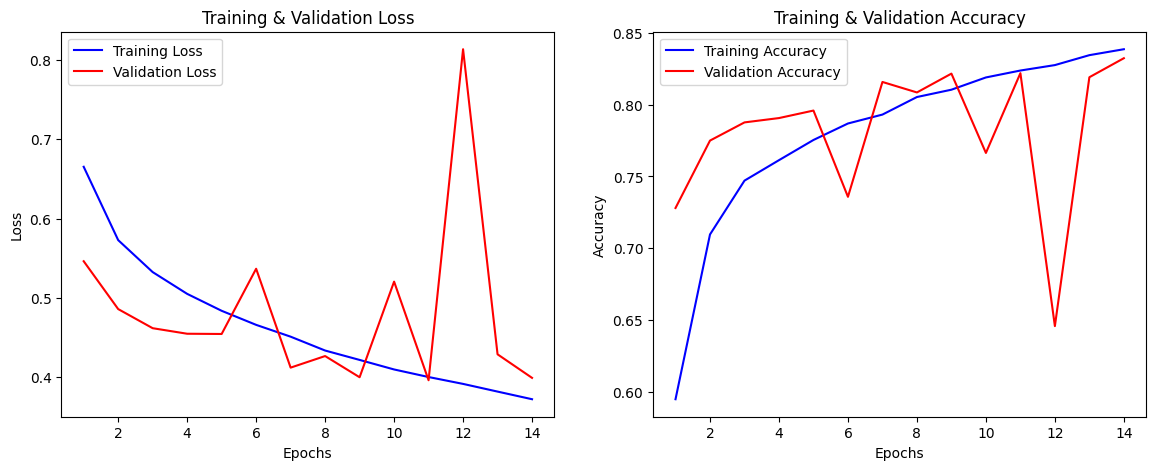

In [70]:
%matplotlib inline
plot_training_curves(history)

In [57]:
from keras.layers import BatchNormalization

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=300,
              weights=[embedding_matrix],
              input_length=300,
              trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [58]:
from keras.optimizers import AdamW

optimizer = AdamW(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3,         
                               restore_best_weights=True,
                               verbose=1)


history = model.fit(X_train, y_train, 
                    epochs=25, 
                    batch_size=64, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping],
                    class_weight=class_weight_dict)

Epoch 1/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 0.5492 - loss: 0.6964 - val_accuracy: 0.7280 - val_loss: 0.5461
Epoch 2/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - accuracy: 0.6971 - loss: 0.5866 - val_accuracy: 0.7750 - val_loss: 0.4857
Epoch 3/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - accuracy: 0.7416 - loss: 0.5391 - val_accuracy: 0.7877 - val_loss: 0.4616
Epoch 4/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - accuracy: 0.7563 - loss: 0.5099 - val_accuracy: 0.7907 - val_loss: 0.4546
Epoch 5/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - accuracy: 0.7752 - loss: 0.4844 - val_accuracy: 0.7960 - val_loss: 0.4543
Epoch 6/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - accuracy: 0.7851 - loss: 0.4702 - val_accuracy: 0.7358 - val_loss: 0.5366
Epoch 7/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - accuracy: 0.7943 - loss: 0.4479 - val_accuracy: 0.8159 - val_loss: 0.4118
Epoch 8/25
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 51s 37ms/step - accuracy: 0.8040 -

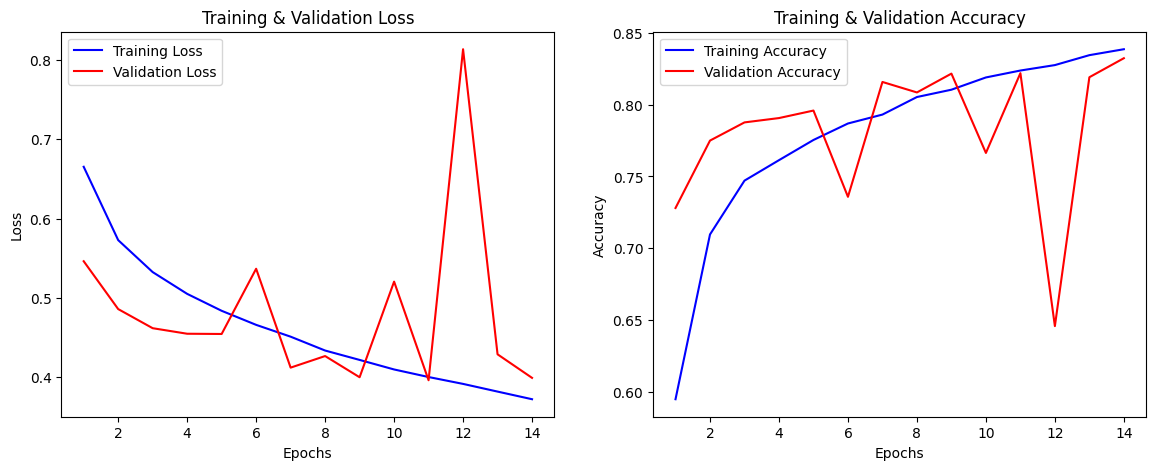

In [60]:
%matplotlib inline
plot_training_curves(history)

## Evaluation

In [61]:
test_df.head()

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,163740,Mirtazapine,depression,"""i've tried a few antidepressants over the yea...",10.0,"February 28, 2012",22,68
1,206473,Mesalamine,"crohn's disease, maintenance","""my son has crohn's disease and has done very ...",8.0,"May 17, 2009",17,48
2,39293,Contrave,weight loss,"""contrave combines drugs that were used for al...",9.0,"March 5, 2017",35,143
3,97768,Cyclafem 1 / 35,birth control,"""i have been on this birth control for one cyc...",9.0,"October 22, 2015",4,149
4,208087,Zyclara,keratosis,"""4 days in on first 2 weeks. using on arms an...",4.0,"July 3, 2014",13,60


In [62]:
test_df['sentiment'] = test_df['rating'].apply(lambda x: 'positive' if x > 6 else 'negative')

In [63]:
tqdm.pandas(desc="Preprocessing reviews")
test_df['processed_review'] = test_df['review'].progress_apply(lambda x: preprocess_text(x))

tqdm.pandas(desc="Detecting language codes")
test_df["language_code"] = test_df["review"].progress_apply(find_language_codes)

test_df = test_df[test_df['language_code'] == Language.ENGLISH]
test_df[['review', 'processed_review', 'sentiment']].head()

Detecting language codes: 100%|██████████| 46108/46108 [00:54<00:00, 853.63it/s]


,review,processed_review,sentiment
0,"""i've tried a few antidepressants over the yea...",i've tried a few antidepressants over the year...,positive
1,"""my son has crohn's disease and has done very ...",my son has crohn's disease and has done very w...,positive
2,"""contrave combines drugs that were used for al...",contrave combines drugs that were used for alc...,positive
3,"""i have been on this birth control for one cyc...",i have been on this birth control for one cycl...,positive
4,"""4 days in on first 2 weeks. using on arms an...",<NUMBER> days in on first <NUMBER> weeks. usin...,negative


In [64]:
X_test = transform_data(test_df, tokenizer)
y_test = test_df['sentiment'].map(sentiment_dict).values

In [65]:
from sklearn.metrics import confusion_matrix, classification_report
from pprint import pprint

y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(int)

1441/1441 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step


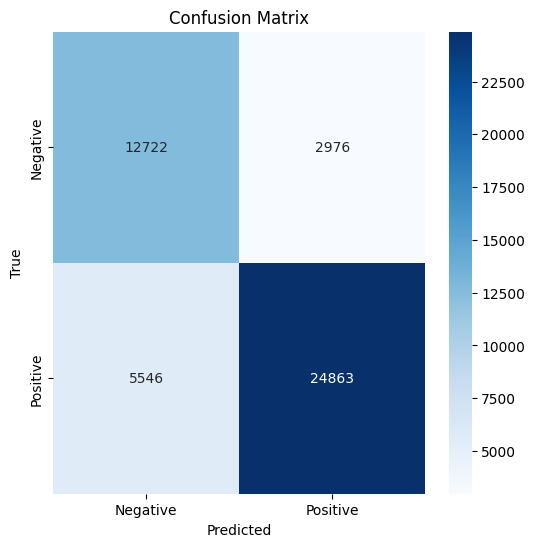

In [66]:
cm = confusion_matrix(y_test, y_pred_bin)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [67]:
report = classification_report(y_test, y_pred_bin, target_names=['Negative', 'Positive'])
pprint(report)

('              precision    recall  f1-score   support\n'
 '\n'
 '    Negative       0.70      0.81      0.75     15698\n'
 '    Positive       0.89      0.82      0.85     30409\n'
 '\n'
 '    accuracy                           0.82     46107\n'
 '   macro avg       0.79      0.81      0.80     46107\n'
 'weighted avg       0.83      0.82      0.82     46107\n')


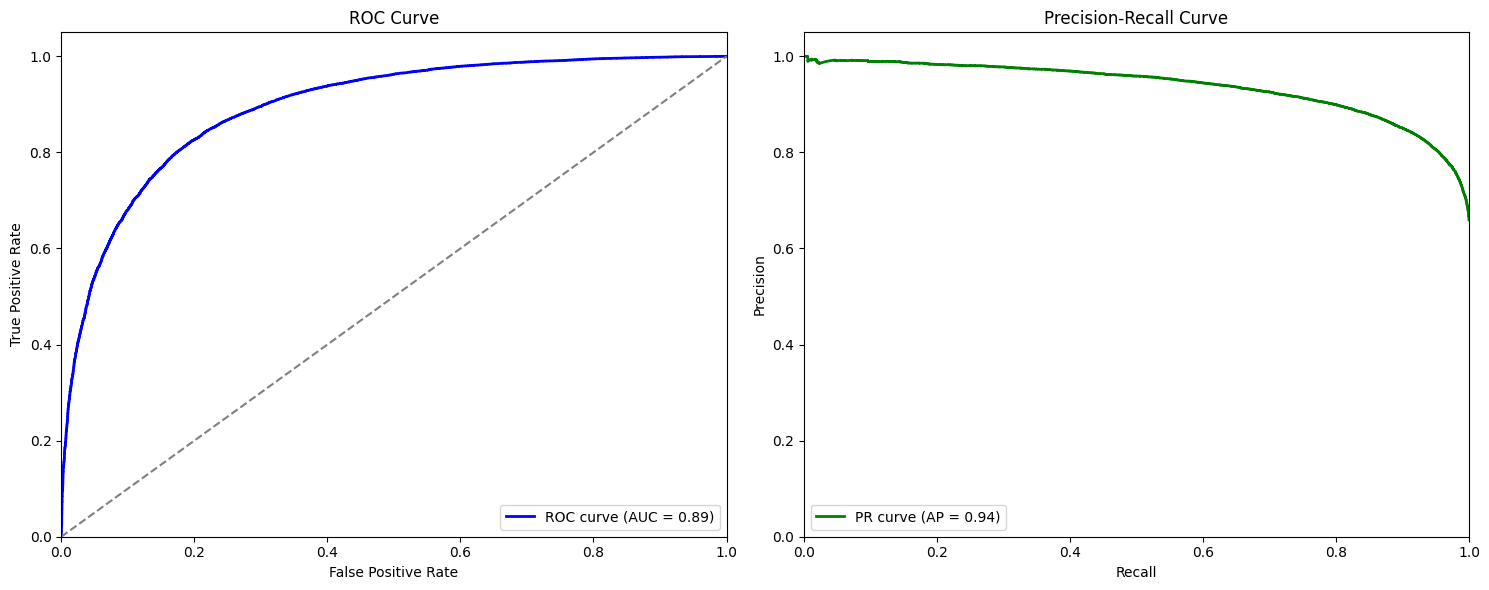

In [68]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--') 
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc='lower right')

# Precision-Recall Curve
ax2.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc='lower left')

# Show the plot
plt.tight_layout()
plt.show()

## Downloading Dataset - IMDB Dataset

A movie review sentiment analysis dataset is used to compare the model architecture performance as the second dataset. 

Link: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format

In [69]:
path = kagglehub.dataset_download("columbine/imdb-dataset-sentiment-analysis-in-csv-format")
print("Path to dataset files:", path)

Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format/versions/1


In [73]:
train_df = os.path.join(path, "Train.csv")
val_df = os.path.join(path, "Valid.csv")
test_df = os.path.join(path, "Test.csv")

train_df = pd.read_csv(train_df)
val_df = pd.read_csv(val_df)
test_df = pd.read_csv(test_df)

In [74]:
train_df.shape, val_df.shape, test_df.shape 

((40000, 2), (5000, 2), (5000, 2))

## Exploratory Data Analysis - IMDB Dataset

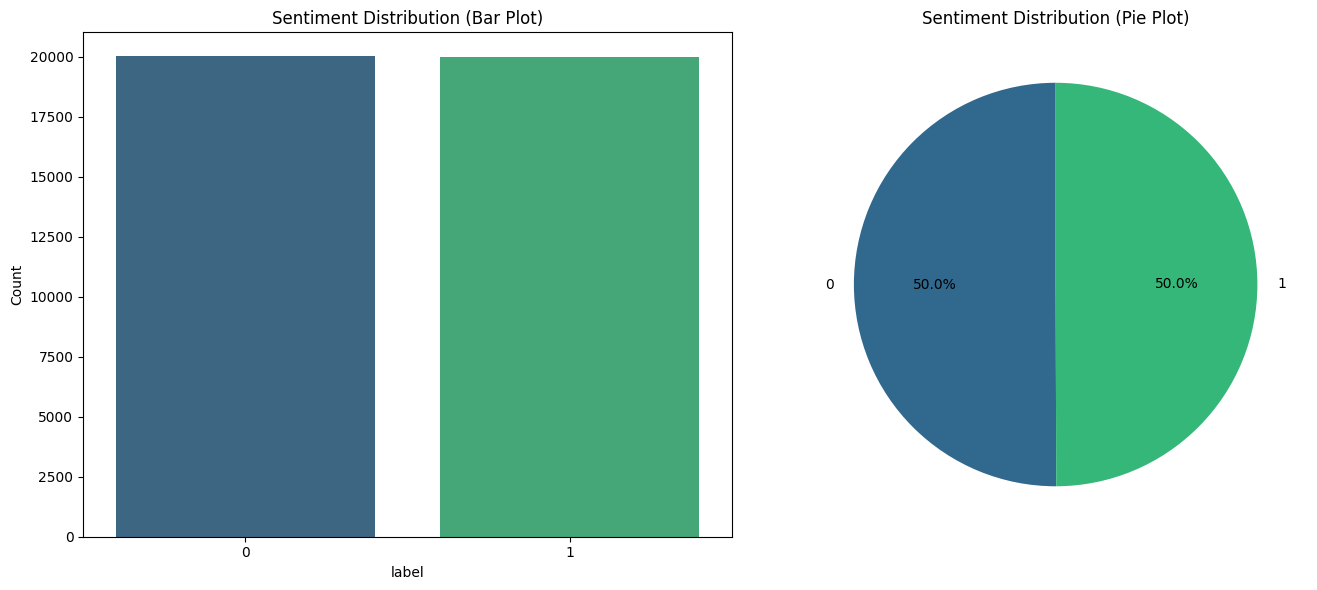

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(data=train_df, x='label', ax=axes[0], palette='viridis')
axes[0].set_title('Sentiment Distribution (Bar Plot)')
axes[0].set_ylabel('Count')

sentiment_counts = train_df['label'].value_counts()
axes[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(sentiment_counts)))
axes[1].set_title('Sentiment Distribution (Pie Plot)')

plt.tight_layout()
plt.show()

In [77]:
train_df["word_count"] = train_df["text"].apply(lambda x: len(str(x).split()))
train_df["char_count"] = train_df["text"].apply(lambda x: len(str(x)))

train_df[["word_count", "char_count"]].describe()

,word_count,char_count
count,40000.000000,40000.000000
mean,231.339250,1310.293250
std,171.194123,988.358599
min,4.000000,32.000000
25%,126.000000,698.000000
50%,173.000000,973.000000
75%,282.000000,1596.000000
max,2470.000000,13704.000000


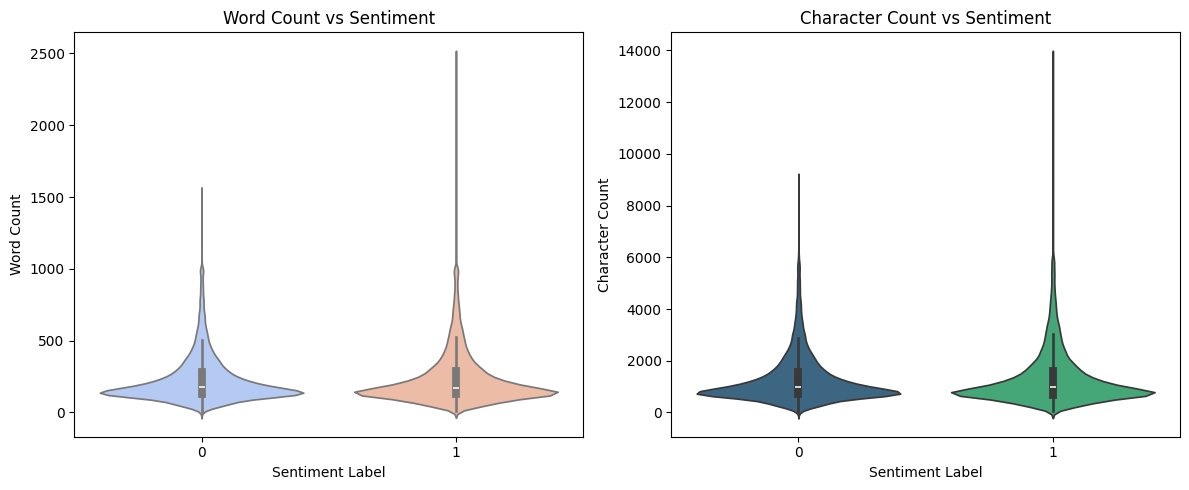

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(x=train_df["label"], y=train_df["word_count"], ax=axes[0], palette="coolwarm")
axes[0].set_title("Word Count vs Sentiment")
axes[0].set_xlabel("Sentiment Label")
axes[0].set_ylabel("Word Count")

sns.violinplot(x=train_df["label"], y=train_df["char_count"], ax=axes[1], palette="viridis")
axes[1].set_title("Character Count vs Sentiment")
axes[1].set_xlabel("Sentiment Label")
axes[1].set_ylabel("Character Count")

plt.tight_layout()
plt.show()

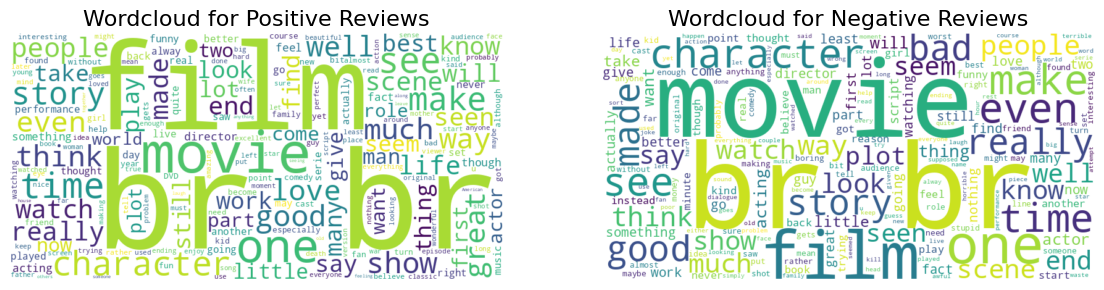

In [80]:
from wordcloud import WordCloud

positive_reviews = train_df[train_df['label'] == 1]['text']
negative_reviews = train_df[train_df['label'] == 0]['text']

positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)

# Generate word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(negative_text)

# Plot positive wordcloud
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Positive Reviews', fontsize=16)

# Plot negative wordcloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Negative Reviews', fontsize=16)

plt.show()

In [82]:
def find_language_codes(text):
    cleaned_text = text.replace("\n", "") 
    return detector.detect_language_of(text)

tqdm.pandas(desc="Detecting language codes")
train_df["language_code"] = train_df["text"].progress_apply(find_language_codes)
train_df.head(3)

Detecting language codes: 100%|██████████| 40000/40000 [01:50<00:00, 361.02it/s]


,text,label,word_count,char_count,language_code
0,I grew up (b. 1965) watching and loving the Th...,0,151,874,Language.ENGLISH
1,"When I put this movie in my DVD player, and sa...",0,326,1811,Language.ENGLISH
2,Why do people who do not know what a particula...,0,184,983,Language.ENGLISH


In [84]:
for i in train_df[train_df['language_code'] != Language.ENGLISH]['text']:
    print(i, end="\n\n")

Tom Clancy uses "Alesandr Nevsky" in his book "Red Storm Rising". In the book, Nevksy was show in theatres across Russia as a prelude to the Soviet invasion of West Germany. I felt I had to check it out. It was excellant! The cinematography was magnificent and storyline incredible. I do not regret watching this movie and added in to my collection.



In [86]:
tqdm.pandas()

def count_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    urls = re.findall(url_pattern, text)
    return len(urls)

train_df['num_urls'] = train_df['text'].progress_apply(count_urls)
print(train_df[train_df['num_urls'] > 0].shape)
display(train_df[train_df['num_urls'] > 0].head(3))

100%|██████████| 40000/40000 [00:00<00:00, 72695.23it/s]

(149, 6)


,text,label,word_count,char_count,language_code,num_urls
205,"I just saw this movie on HBO, and it was reall...",1,134,819,Language.ENGLISH,1
661,Inarguably one of the most interesting filmmak...,1,987,5879,Language.ENGLISH,1
1049,"i really love this movie , i saw it for the fi...",1,129,614,Language.ENGLISH,1


In [87]:
def has_numbers(text):
    number_pattern = r'\b\d+([.,]\d+)*\b'
    return bool(re.search(number_pattern, text))

train_df['has_numbers'] = train_df['text'].progress_apply(has_numbers)
print(train_df[train_df['has_numbers'] > 0].shape)
display(train_df[train_df['has_numbers'] > 0].head(3))

100%|██████████| 40000/40000 [00:00<00:00, 47502.98it/s]

(20765, 7)


,text,label,word_count,char_count,language_code,num_urls,has_numbers
0,I grew up (b. 1965) watching and loving the Th...,0,151,874,Language.ENGLISH,0,True
2,Why do people who do not know what a particula...,0,184,983,Language.ENGLISH,0,True
8,It may be the remake of 1987 Autumn's Tale aft...,1,188,1137,Language.ENGLISH,0,True


In [90]:
def has_html(text):
    return bool(BeautifulSoup(text, "html.parser").find())

train_df["has_html"] = train_df["text"].progress_apply(has_html)
print(train_df[train_df['has_html'] > 0].shape)
display(train_df[train_df['has_html'] > 0].head(3))

100%|██████████| 40000/40000 [00:06<00:00, 6011.56it/s]

(23365, 8)


,text,label,word_count,char_count,language_code,num_urls,has_numbers,has_html
1,"When I put this movie in my DVD player, and sa...",0,326,1811,Language.ENGLISH,0,False,True
4,Im a die hard Dads Army fan and nothing will e...,1,178,983,Language.ENGLISH,0,False,True
5,A terrible movie as everyone has said. What ma...,0,102,596,Language.ENGLISH,0,False,True


In [94]:
print(train_df[train_df['has_html'] > 0].iloc[1,0])

Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD's and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant move - especially when he wouldn't cash the cheque (something that is rarely done now).<br /><br />It follows through the early years of getting equipment and uniforms, starting up and training. All in all, its a great film for a boring Sunday afternoon. <br /><br />Two draw backs. One is the Germans bogus dodgy accents (come one, Germans cant pronounced the letter "W" like us) and Two The casting of Liz Frazer instead of the familiar Janet Davis. I like Liz in other films like the carry ons but she doesn't carry it correctly in this and Janet Davis would have been the better choice.


In [97]:
def count_hashtags(text):
    hashtag_pattern = r'#\S+'
    hashtags = re.findall(hashtag_pattern, text)
    return len(hashtags)

train_df['count_hashtags'] = train_df['text'].progress_apply(count_hashtags)
print(train_df[train_df['count_hashtags'] > 0].shape)
display(train_df[train_df['count_hashtags'] > 0].head(3))

100%|██████████| 40000/40000 [00:00<00:00, 487797.68it/s]

(240, 9)


,text,label,word_count,char_count,language_code,num_urls,has_numbers,has_html,count_hashtags
147,Better than I expected from a film selling its...,1,107,627,Language.ENGLISH,0,False,False,1
148,"My thoughts on the movie, 9<br /><br />It was ...",0,625,3560,Language.ENGLISH,0,True,True,8
322,"Oh boy, where do I go with this one? Herendous...",0,115,654,Language.ENGLISH,0,False,True,1


In [104]:
print(train_df[train_df['count_hashtags'] > 0].iloc[1,0])

My thoughts on the movie, 9<br /><br />It was not good, not good at all. Visually, it was great. I was pleased with the pacing, the camera angles, etc. However, the characters? eh, kinda bland. Plot? It sucked.<br /><br />This movie seemed more new age crap than anything else. Organized religion is presented as cowardly and fearful. Science isn't portrayed any better. It creates a monster weapon that kills everything... but "souls" have the power to destroy monsters and bring life? Really?<br /><br />That's something that bites my ass a bit too. Here we have a CGI movie... created with science... and they're using it to give us the message that science will destroy the world while promoting the idea that spirituality will save us? At least they had the decency to have one of the characters ask,<br /><br />"Okay, so now what?" (or something similar). I couldn't hear it too well because of the crowd immediately getting up and making a break for the exit. It was a "okay... it was just bar

In [106]:
def check_emoticons(text):
    emoticon_count = 0
    for emoticon in EMOTICONS_EMO:
        if emoticon in text:
            emoticon_count += 1
    return emoticon_count

train_df['num_emoticons'] = train_df['text'].progress_apply(check_emoticons)
print(train_df[train_df['num_emoticons'] > 0].shape)
display(train_df[train_df['num_emoticons'] > 0].head(3))

100%|██████████| 40000/40000 [00:07<00:00, 5391.55it/s]

(1866, 10)


,text,label,word_count,char_count,language_code,num_urls,has_numbers,has_html,count_hashtags,num_emoticons
11,If you haven't seen the gong show TV series th...,0,264,1298,Language.ENGLISH,0,True,True,0,1
20,Ever since I heard of the Ralph Bakshi version...,1,94,520,Language.ENGLISH,0,False,False,0,1
37,A feminist tract in which if you the viewer be...,0,674,3808,Language.ENGLISH,0,False,True,0,1


In [107]:
def count_emojis(text):
    emoji_count = 0
    for emoji_shortcode in EMOJI_UNICODE:
        if emoji_shortcode in text:
            emoji_count += text.count(emoji_shortcode)
    return emoji_count

train_df['num_emojis'] = train_df['text'].progress_apply(count_emojis)
print(train_df[train_df['num_emojis'] > 0].shape)
display(train_df[train_df['num_emojis'] > 0].head(3))

100%|██████████| 40000/40000 [01:03<00:00, 625.17it/s]


(0, 11)


,text,label,word_count,char_count,language_code,num_urls,has_numbers,has_html,count_hashtags,num_emoticons,num_emojis


In [108]:
def count_elongated_words(text):
    elongated_pattern = r'\b(\S*?)(.)\2{2,}\b'
    elongated_words = re.findall(elongated_pattern, text)
    return len(elongated_words)

train_df['count_elongated_words'] = train_df['text'].progress_apply(count_elongated_words)
print(train_df[train_df['count_elongated_words'] > 0].shape)
display(train_df[train_df['count_elongated_words'] > 0].head(3))

100%|██████████| 40000/40000 [00:04<00:00, 8609.70it/s]

(5480, 12)


,text,label,word_count,char_count,language_code,num_urls,has_numbers,has_html,count_hashtags,num_emoticons,num_emojis,count_elongated_words
7,I caught this film on AZN on cable. It sounded...,0,271,1489,Language.ENGLISH,0,False,True,0,0,0,2
25,"First, I should mention that I really enjoyed ...",0,451,2699,Language.ENGLISH,0,True,True,0,0,0,1
30,"I saw this film via one of the actors' agents,...",1,182,1012,Language.ENGLISH,0,True,True,0,0,0,1


In [111]:
print(train_df[train_df['count_elongated_words'] > 0].iloc[2, 0])

I saw this film via one of the actors' agents, and it surely conforms with a great deal that comes out of Sth. Australia in terms of the overall *tone,* which is rightly dark and moody.<br /><br />I thought the little boy in the film was excellent. Mostly kid actors are *hammed up* and embarrassing but not in this case. He was really very good. In terms of the *surrealism* thingy mentioned by jingo, well, I just think this film is plain 'weird.' It's a real weirdo film, with weirdo locations, storyline, weird stuff going on the whole time. But 'good' weird as opposed to 'bad'.<br /><br />Its hard to think of other movies like it, but its not at all like CARS ATE Paris, maybe more like a REPULSION, but actually I think more like a Hammer movie from the 60's. Its certainly has an interesting mind working behind it.<br /><br />JINGO, My question is also about the title. Why Modern Love?? Anyone? Also, jingo, what did you mean by "god Forsaken" when you were talking about Australia, hmmm? 

## Data Preprocessing - IMDB Dataset

In [138]:
def preprocess_text(text):
    # Convert emoticons & fix negations
    sentence = convert_emoticons(text)
    sentence = fix_negation(sentence.lower().split())
    sentence = " ".join(sentence)

    sentence = BeautifulSoup(sentence, "html.parser").get_text()
    sentence = re.sub(r'\b(\w+)(\1{2,})\b', r'\1\1', sentence)

    # Remove escape characters, @, #, and brackets
    sentence = re.sub(r'\\|[@#\[\]{}()<>\*]', '', sentence)  

    # Replace URLs, numbers, and punctuation repetitions
    sentence = re.sub(r'https?://\S+|www\.\S+', '<URL>', sentence)
    sentence = re.sub(r'\b(\d{4})\'s\b', r'<DATE>', sentence)
    sentence = re.sub(r'\d+([.,]\d+)?', '<NUMBER>', sentence)
    sentence = re.sub(r'([!?.])\1{2,}', r'\1 <REPEAT>', sentence)  

    return sentence

In [139]:
tqdm.pandas(desc="Preprocessing reviews")
train_df['processed_review'] = train_df['text'].progress_apply(lambda x: preprocess_text(x))
train_df[['text', 'processed_review', 'label']].head()

Preprocessing reviews: 100%|██████████| 40000/40000 [00:40<00:00, 996.25it/s] 


,text,processed_review,label
0,I grew up (b. 1965) watching and loving the Th...,i grew up b. <NUMBER> watching and loving the ...,0
1,"When I put this movie in my DVD player, and sa...","when i put this movie in my dvd player, and sa...",0
2,Why do people who do not know what a particula...,why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,even though i have great interest in biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,im a die hard dads army fan and nothing will e...,1


In [141]:
print(train_df[['text', 'processed_review', 'label']].iloc[11, 1])

if you haven't seen the gong show tv series then you won't like this movie much at all, not that knowing the series makes this a great movie. i give it a <NUMBER> out of <NUMBER> because a few things make it kind of amusing that help make up for its obvious problems.<NUMBER> it's a funny snapshot of the era it was made in, the late <DATE> and early <DATE>. <NUMBER> you get a lot of funny cameos of people you've seen on the show. <NUMBER> it's interesting to see chuck the host when he isn't doing his on air tv personality. <NUMBER> you get to see a lot of bizarre people doing all sorts of weirdness just like you see on the tv show.i won't list all the bad things because there's a lot of them, but here's a few of the most prominent.<NUMBER> the gong show movie has a lot of the actual tv show clips which gets tired at movie length. <NUMBER> the movie's story line outside of the clip segments is very weak and basically is made up of just one plot point. <NUMBER> chuck is actually halfway d

In [142]:
tqdm.pandas(desc="Preprocessing reviews")
val_df['processed_review'] = val_df['text'].progress_apply(lambda x: preprocess_text(x))
val_df[['text', 'processed_review', 'label']].head()

Preprocessing reviews: 100%|██████████| 5000/5000 [00:05<00:00, 993.32it/s] 


,text,processed_review,label
0,It's been about 14 years since Sharon Stone aw...,it's been about <NUMBER> years since sharon st...,0
1,someone needed to make a car payment... this i...,someone needed to make a car payment. <REPEAT>...,0
2,The Guidelines state that a comment must conta...,the guidelines state that a comment must conta...,0
3,This movie is a muddled mish-mash of clichés f...,this movie is a muddled mish-mash of clichés f...,0
4,Before Stan Laurel became the smaller half of ...,before stan laurel became the smaller half of ...,0


## Text Embedding Generation - IMDB Dataset

In [143]:
X_train, tokenizer = prepare_data(train_df)
X_valid = transform_data(val_df, tokenizer)

In [145]:
embedding_matrix, vocab_size = prepare_glove_embeddings(tokenizer, 'glove.6B.300d.txt')

100%|██████████| 115376/115376 [00:00<00:00, 144638.13it/s]


In [149]:
y_train = train_df['label']
y_valid = val_df['label']

## Modelling - IMDB Dataset

In [146]:
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=300,
              weights=[embedding_matrix],
              input_length=300,
              trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [148]:
optimizer = AdamW(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [150]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3,         
                               restore_best_weights=True,
                               verbose=1)


history = model.fit(X_train, y_train, 
                    epochs=25, 
                    batch_size=64, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping],
                    class_weight=class_weight_dict)

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.5414 - loss: 0.7147 - val_accuracy: 0.7822 - val_loss: 0.5072
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7602 - loss: 0.5221 - val_accuracy: 0.8060 - val_loss: 0.4391
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.7969 - loss: 0.4655 - val_accuracy: 0.8328 - val_loss: 0.4000
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.8101 - loss: 0.4329 - val_accuracy: 0.8118 - val_loss: 0.4373
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.8215 - loss: 0.4085 - val_accuracy: 0.8462 - val_loss: 0.3750
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.8298 - loss: 0.3936 - val_accuracy: 0.8518 - val_loss: 0.3703
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.8410 - loss: 0.3727 - val_accuracy: 0.8536 - val_loss: 0.3586
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.8424 - loss: 0.3652 - 

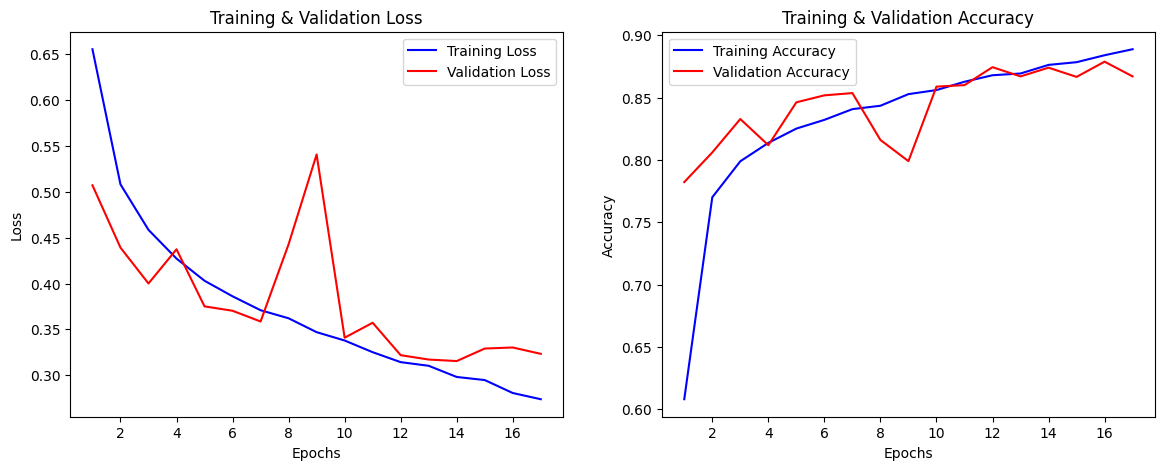

In [151]:
%matplotlib inline
plot_training_curves(history)

## Evaluation - IMDB Dataset

In [152]:
tqdm.pandas(desc="Preprocessing reviews")
test_df['processed_review'] = test_df['text'].progress_apply(lambda x: preprocess_text(x))
test_df[['text', 'processed_review', 'label']].head()

Preprocessing reviews: 100%|██████████| 5000/5000 [00:05<00:00, 987.33it/s] 


,text,processed_review,label
0,I always wrote this series off as being a comp...,i always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,<NUMBER>st watched <NUMBER>/<NUMBER>/<NUMBER> ...,0
2,This movie was so poorly written and directed ...,this movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,the most interesting thing about miryang secre...,1
4,"when i first read about ""berlin am meer"" i did...","when i first read about ""berlin am meer"" i did...",0


In [153]:
X_test = transform_data(test_df, tokenizer)
y_test = test_df['label']

In [154]:
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(int)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


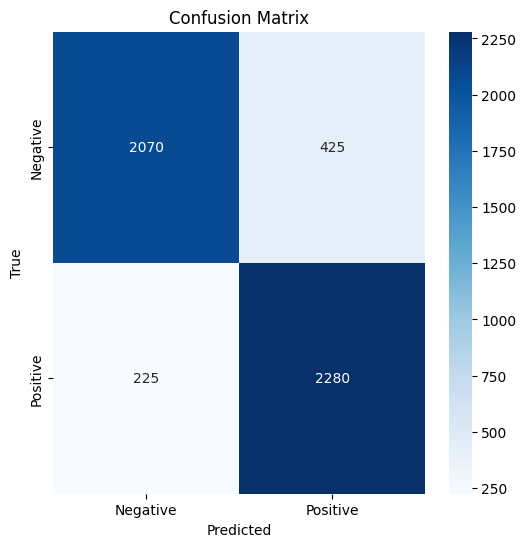

In [155]:
cm = confusion_matrix(y_test, y_pred_bin)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [156]:
report = classification_report(y_test, y_pred_bin, target_names=['Negative', 'Positive'])
pprint(report)

('              precision    recall  f1-score   support\n'
 '\n'
 '    Negative       0.90      0.83      0.86      2495\n'
 '    Positive       0.84      0.91      0.88      2505\n'
 '\n'
 '    accuracy                           0.87      5000\n'
 '   macro avg       0.87      0.87      0.87      5000\n'
 'weighted avg       0.87      0.87      0.87      5000\n')


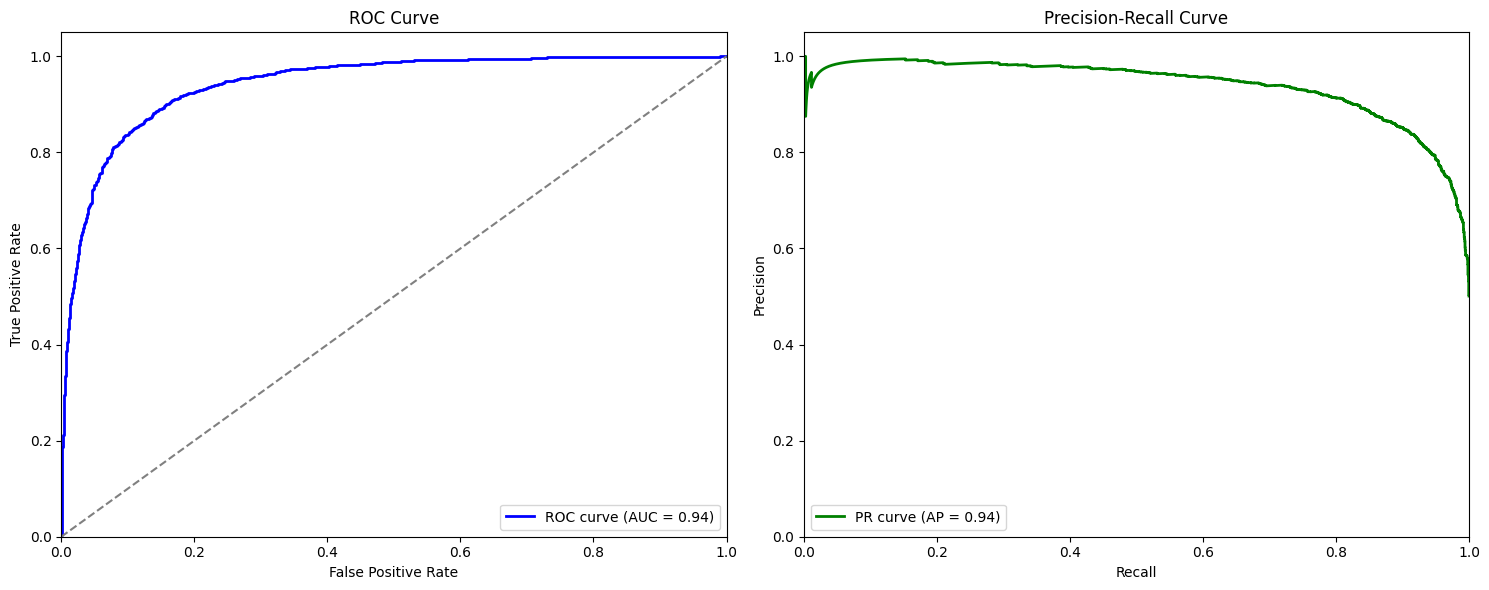

In [157]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--') 
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc='lower right')

# Precision-Recall Curve
ax2.plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc='lower left')

# Show the plot
plt.tight_layout()
plt.show()

## Performance Comparison

**Balanced Performance on IMDb Dataset:**

- The model achieves an accuracy of 0.87 with nearly equal support for both classes (2495 negative and 2505 positive), leading to balanced F1-scores (0.86 for negative and 0.88 for positive).
- With an AUC of 0.94 and a PR curve (AP) of 0.94, the model demonstrates excellent discrimination and ranking ability between positive and negative sentiments.
- This balance indicates that the model is well-calibrated and effectively minimizes both false positives and false negatives in a balanced dataset.

**Challenges on the Drug Review Dataset:**

- The drug review dataset is notably imbalanced (15,698 negative vs. 30,409 positive), which affects the model’s performance differently across classes. Due to this, looking at macro metrics would make more sense.
- The macro averages (precision: 0.79, recall: 0.81, F1: 0.80) show the average performance across both classes without taking into account class imbalances. It highlights that the model is overall underperforming in the negative class, pulling down the averages slightly.
- While the positive class maintains a strong precision of 0.89 and an F1-score of 0.85, the negative class shows a lower precision of 0.70 despite a decent recall of 0.81, resulting in an overall negative F1-score of 0.75. Look
- The overall accuracy is lower at 0.82, and the AUC drops to 0.89, further highlighting that the model struggles more with distinguishing negative reviews in an imbalanced context.

**Overall Comments**

- Both datasets exhibit a strong PR curve (AP of 0.94), suggesting that regardless of the overall accuracy or class-specific precision/recall, the model is effective at ranking positive examples higher than negatives. This consistency is particularly important in imbalanced datasets, as it shows that the model's ability to prioritize relevant examples remains robust.
- Overall, both models perform reasonably well, with the IMDb dataset showing a slight edge in performance. This suggests that the combination of GloVe embeddings, the BiLSTM architecture, and the selected hyperparameters are well-suited for the sentiment analysis task, effectively capturing the nuances in text and distinguishing between positive and negative sentiments regardless of domain.